## Read ShorelineMonitor data from Zarr

A small sample (n=2000) of the ShorelineMonitor data (yearly averages) is saved as a zarr store. This notebook shows how to load the data from that zarr store with Python into, e.g., Xarray, and perform some simple operations. 

Next steps:
- process all shorelinemonitor data into the zarr storage
- include explicit chunking?
- move to cloud
- load data with rioxarray to include geospatial operations
- provide a few more examples of plots and data operations
- include stac catalogue
- add other shorelinemonitor feature, such as country, sandy_flag etc.?

Requirements:
- zarr
- xarray
- dask 

Optional:
- geopandas
- rioxarray

In [1]:
# Optional; code formatter, installed as jupyter lab extension
%load_ext lab_black

In [2]:
import os
import pathlib
import sys

# make root directories importable by appending root to path
cwd = pathlib.Path().resolve()
sys.path.append(os.path.dirname(cwd))

# OS independent path configurations
root = pathlib.Path().home().root
coclico_dir = pathlib.Path(root, "p", "11205479-coclico")

# shoreline monitor paths
sm_dir = coclico_dir.joinpath("data", "16_shorelinemonitor")
sm_zstore_path = sm_dir.joinpath("shorelinemonitor.zarr")

# Extreme Sea Level (JRC) paths
esl_dir = coclico_dir.joinpath("data", "03_sea_level_jrc")
esl_zstore_path = esl_dir.joinpath("CoastAlRisk_Europe_ESL_Historical.zarr")

### Load data into xarray from zarr

### Extreme Sea Level

In [3]:
import xarray as xr
import zarr

esl = xr.open_zarr(esl_zstore_path)
esl

<xarray.Dataset>
Dimensions:    (npoints: 11014, nrp: 8)
Coordinates:
    latitude   (npoints) float64 dask.array<chunksize=(11014,), meta=np.ndarray>
    longitude  (npoints) float64 dask.array<chunksize=(11014,), meta=np.ndarray>
Dimensions without coordinates: npoints, nrp
Data variables:
    eewl       (npoints, nrp) float64 dask.array<chunksize=(5507, 4), meta=np.ndarray>
    ensmbl     float32 ...
    esl        (npoints, nrp) float64 dask.array<chunksize=(5507, 4), meta=np.ndarray>
    rp         (nrp) float32 dask.array<chunksize=(8,), meta=np.ndarray>
Attributes:
    Institution:      Joint European Research Center, Directorate for Space, ...
    Project Acronym:  CoastAlRisk
    Project Name:     Prototype of a first Global Integrated Coastal Impact-b...
    disclaimer:       Unless the following would not be permitted or valid un...
    email:            michail.vousdoukas@ec.europa.eu
    reference:         Vousdoukas MI., Mentaschi L., Voukouvalas E., Verlaan ...
    terms_for_use:    European Union, 1995-2015.\nReuse is authorised, provid...
    title:            Extreme Sea Levels
    version:          1.2

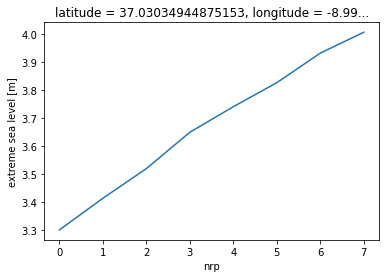

In [4]:
esl.isel(npoints=0)["esl"].plot()

### ShorelineMonitor example

In [5]:
import xarray as xr
import zarr


sm = xr.open_zarr(sm_zstore_path)

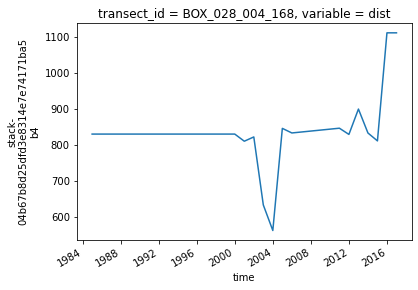

In [6]:
# Example: get first transect by index and plot
sm.isel(transect_id=0).to_array().plot()

### Additional info about zarr store's

Just some examples to show how the zarr store is now formatted 

In [7]:
# connect to zarr store with open and print general info
sm_zstore = zarr.open(sm_zstore_path)
sm_zstore.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,5
No. arrays,5
No. groups,0
Arrays,"dist, lat, lon, time, transect_id"


In [8]:
# or print store tree
sm_zstore.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='dist (1996, 33) float…

In [9]:
# the zarr directory also contains "consolidated metadata"
os.listdir(sm_zstore_path)

['.zattrs',
 'time',
 '.zgroup',
 'transect_id',
 'dist',
 '.zmetadata',
 'lat',
 'lon']

### Inspect certain zarr array  

Here, note that the chunk shape (998, 33) was detected automatically by zarr. In future, to get optimal io speed, we should think about the use case and set the chunk dimension according to that use case. For example, for the showing the time-series per transect the store should be chunked across the transect_id dimension, but not over the years. 

In [10]:
sm_zstore["dist"].info

Name,/dist
Type,zarr.core.Array
Data type,float64
Shape,"(1996, 33)"
Chunk shape,"(998, 33)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,526944 (514.6K)
No. bytes stored,430613 (420.5K)


### Important notes on Zarr from Xarray perspective

Please note: 

1. Zarr can only read/write Zarr groups, but no individual zarr arrays.
2. Zarr arrays do not have dimensions names like NetCDF. Therefore, each Zarr array requires a special array attribute `_ARRAY_DIMENSIONS`. Without this attribute, data cannot be load from zarr into xarray. 

For an extensive discussion see [this entry of the xarray documentation](https://xarray.pydata.org/en/stable/internals/zarr-encoding-spec.html)

The attributes from a certain array can be listed like:

In [11]:
dict(sm_zstore["dist"].attrs)

{'_ARRAY_DIMENSIONS': ['transect_id', 'time'], 'coordinates': 'lon lat'}